# Lab4 - DT

## Набор данных

In [1]:
import pandas as pd

df = pd.read_csv('data/diabetes_dataset.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Разделение на выборки и нормализация

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y = df['Outcome']
X = df.drop(columns=['Outcome'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

In [3]:
def minmax(x, min, max):
    return (float(x) - min) / (max - min)

In [4]:
def normalize(X_train, X_test):
    for category in df.columns:
        if category == 'Outcome':
            continue

        col_train_min = X_train[category].min()
        col_train_max = X_train[category].max()

        col_test_min = X_test[category].min()
        col_test_max = X_test[category].max()
        
        X_train[category] = X_train[category].apply(lambda x: minmax(x, col_train_min, col_train_max))
        X_test[category] = X_test[category].apply(lambda x: minmax(x, col_test_min, col_test_max))

In [5]:
normalize(X_train, X_test)

In [6]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
542,0.714286,0.454545,0.772727,0.323232,0.000000,0.520119,0.317209,0.583333
589,0.000000,0.368687,0.000000,0.000000,0.000000,0.314456,0.110445,0.066667
439,0.428571,0.540404,0.800000,0.000000,0.000000,0.548435,0.275257,0.166667
173,0.071429,0.398990,0.545455,0.424242,0.056738,0.648286,0.254281,0.033333
51,0.071429,0.510101,0.454545,0.151515,0.042553,0.360656,0.189212,0.083333


## Алгоритмы

### Дерево принятия решений

In [7]:
import numpy as np

class DecisionTree:
    class Node:
        def __init__(self, feature, value=None, left=None, right=None):
            self.feature=feature
            self.value=value
            self.left=left
            self.right=right

    def __init__(self, max_depth=None, min_split_size=2,  min_leaf_size=1, min_F=None, features_per_split=None):
        self.max_depth=max_depth
        self.min_split_size=min_split_size
        self.min_leaf_size=min_leaf_size
        self.min_F=min_F
        self.features_per_split=features_per_split
        self.depth=0

    def _compute_impurity(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)

    def _find_best_split(self, X, y):
        n_features = X.shape[1]
        best_F = 0
        best_feature = None
        best_value = None

        if self.features_per_split is None:
            features = range(n_features)
        elif self.features_per_split == 'sqrt':
            features = np.random.choice(n_features, int(np.sqrt(n_features)), replace=False)
        elif self.features_per_split == 'log2':
            features = np.random.choice(n_features, int(np.log2(n_features)), replace=False)
        else:
            features = np.random.choice(n_features, min(n_features, self.features_per_split), replace=False)

        for feature_index in features:
            feature_values = X[:, feature_index]
            for value in np.unique(feature_values):
                left_part = feature_values <= value
                right_part = feature_values > value

                if (self._stop_postconditions(left_part, right_part)):
                    continue

                impurity = self._compute_impurity(y)
                left_impurity = self._compute_impurity(y[left_part])
                right_impurity = self._compute_impurity(y[right_part])

                F = impurity * len(y) - left_impurity * len(y[left_part]) - right_impurity * len(y[right_part])

                if F > best_F:
                    best_F = F
                    best_feature = feature_index
                    best_value = value
        if self.min_F is not None and best_F < self.min_F:
            return None, None
        
        return best_feature, best_value


    def _dominant_feature(self, y):
        features, counts = np.unique(y, return_counts=True)
        return features[np.argmax(counts)]

    def _stop_preconditions(self, depth, n_samples, n_classes):
        return (self.max_depth is not None and depth >= self.max_depth) or \
                    (n_samples < self.min_split_size) or \
                    (n_classes == 1)
    
    def _stop_postconditions(self, left_subset, right_subset):
        return sum(left_subset) < self.min_leaf_size or sum(right_subset) < self.min_leaf_size


    def _split(self, X, y, depth):
        if depth > self.depth:
            self.depth = depth

        n_samples, n_features = X.shape
        n_classes = len(y)

        if (self._stop_preconditions(depth, n_samples, n_classes)):
            return self.Node(self._dominant_feature(y))
        
        split_feature, split_value = self._find_best_split(X, y)

        if split_feature is None:
            return self.Node(self._dominant_feature(y))

        left_subset = X[:, split_feature] <= split_value 
        right_subset = X[:, split_feature] > split_value

        if (self._stop_postconditions(left_subset, right_subset)):
            return self.Node(self._dominant_feature(y))
        
        left_child = self._split(X[left_subset], y[left_subset], depth + 1)
        right_child = self._split(X[right_subset], y[right_subset], depth + 1)

        return self.Node(split_feature, value=split_value, left=left_child, right=right_child)

    def get_depth(self):
        return self.depth

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.tree = self._split(X, y, 0)

    def _predict_single(self, x, node):
        if node.left is None and node.right is None:
            return node.feature
        
        split_feature = node.feature
        split_value = node.value
        if x[split_feature] <= split_value:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)
    
    def predict(self, X):
        return [self._predict_single(x, self.tree) for x in X]

### Случайный лес

In [9]:
class RandomForest:
    def __init__(self, n_trees=5, max_depth=None, min_split_size=2,  min_leaf_size=1, min_F=None, features_per_split=None):
        self.n_trees=n_trees
        self.max_depth=max_depth
        self.min_split_size=min_split_size
        self.min_leaf_size=min_leaf_size
        self.min_F=min_F
        self.features_per_split=features_per_split

    def _dominant_feature(self, y):
        features, counts = np.unique(y, return_counts=True)
        return features[np.argmax(counts)]
    
    def _bootstrap(self, X, y):
        n_samples = X.shape[0]
        X_train = []
        y_train = []
        for _ in range(n_samples):
            random_index=np.random.randint(0, n_samples)
            X_train.append(X[random_index])
            y_train.append(y[random_index])
        return X_train, y_train
        

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.trees = []
        if self.features_per_split is None:
            self.features_per_split = int(np.sqrt(n_features))

        for i in range(self.n_trees):
            X_train, y_train = self._bootstrap(X, y)
            tree = DecisionTree(
                max_depth=self.max_depth, \
                min_split_size=self.min_split_size, \
                min_leaf_size=self.min_leaf_size, \
                min_F=self.min_F, \
                features_per_split=self.features_per_split)
            tree.fit(X_train, y_train)
            self.trees.append(tree)
    
    def predict(self, X):
        predicts = np.array([tree.predict(X) for tree in self.trees])
        return [self._dominant_feature(predicts[:, i]) for i in range(X.shape[0])]


## Задание

### Перебор гиперпараметров библиотечного дерева

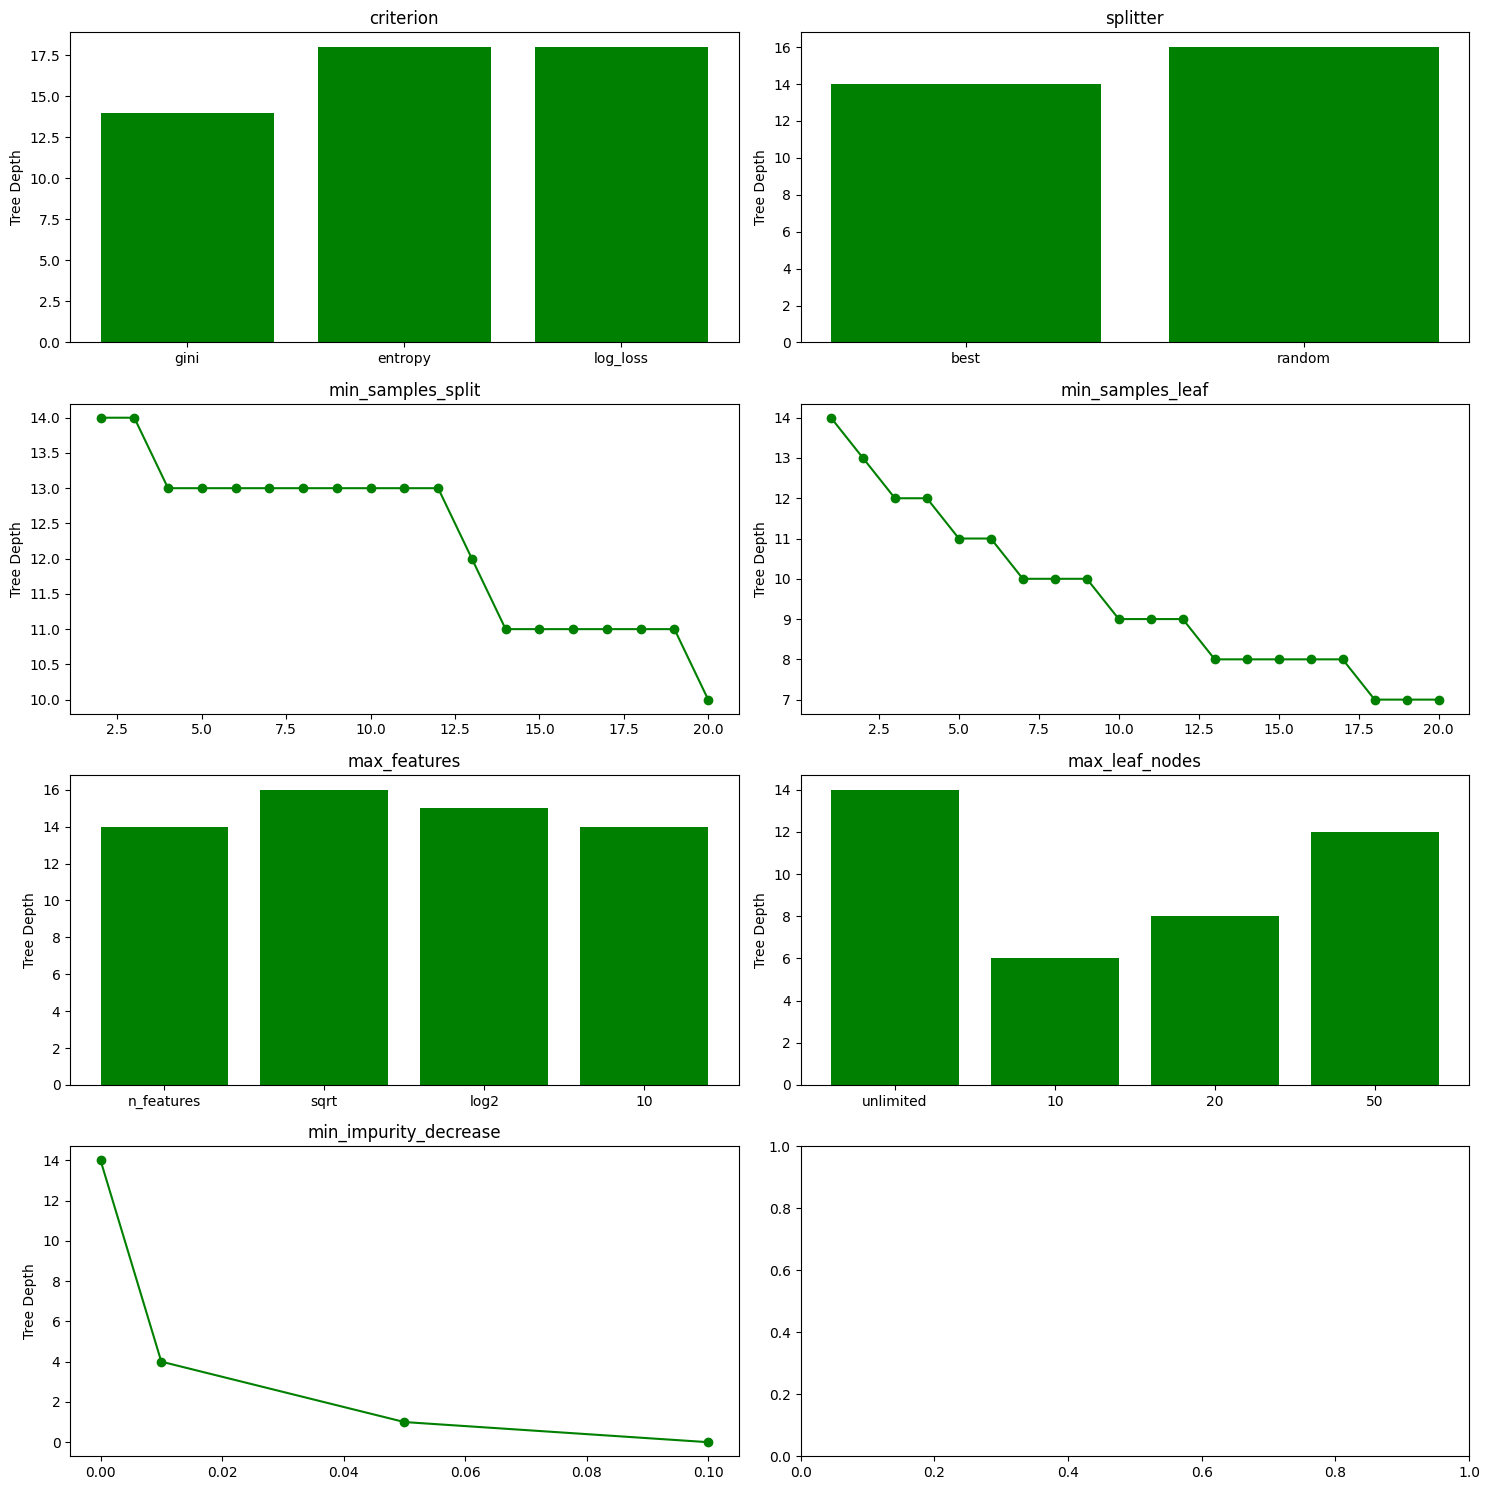

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

params_tree_sk = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "min_samples_split": range(2, 21),
    "min_samples_leaf": range(1, 21),
    "max_features": [None, "sqrt", "log2", 10],
    "max_leaf_nodes": [None, 10, 20, 50],
    "min_impurity_decrease": [0.0, 0.01, 0.05, 0.1]
}

def iterate_through_parameter_sk(name, values):
    depths = []
    for value in values:
        tree_clf = DecisionTreeClassifier(**{name: value})
        tree_clf.fit(X_train, y_train)
        depths.append(tree_clf.get_depth())
    return depths


fig, axes = plt.subplots(4, 2, figsize=(15, 15))
axes = axes.flatten()

for ind, (name, values) in enumerate(params_tree_sk.items()):
    depths = iterate_through_parameter_sk(name, values)
    if name == 'max_features' and values[0] is None:
        values[0] = 'n_features'
    elif name == 'max_leaf_nodes' and values[0] is None:
        values[0] = 'unlimited'

    if name == 'min_samples_split' or name == 'min_samples_leaf' or name == 'min_impurity_decrease':
        axes[ind].plot(values, depths, color='green', marker='o')
    else:
        axes[ind].bar(list(map(str, values)), depths, color='green')
    axes[ind].set_title(name)
    axes[ind].set_ylabel("Tree Depth")

plt.tight_layout()
plt.show()

### Перебор гиперпараметров для собственной реализации

4it [00:50, 12.51s/it]


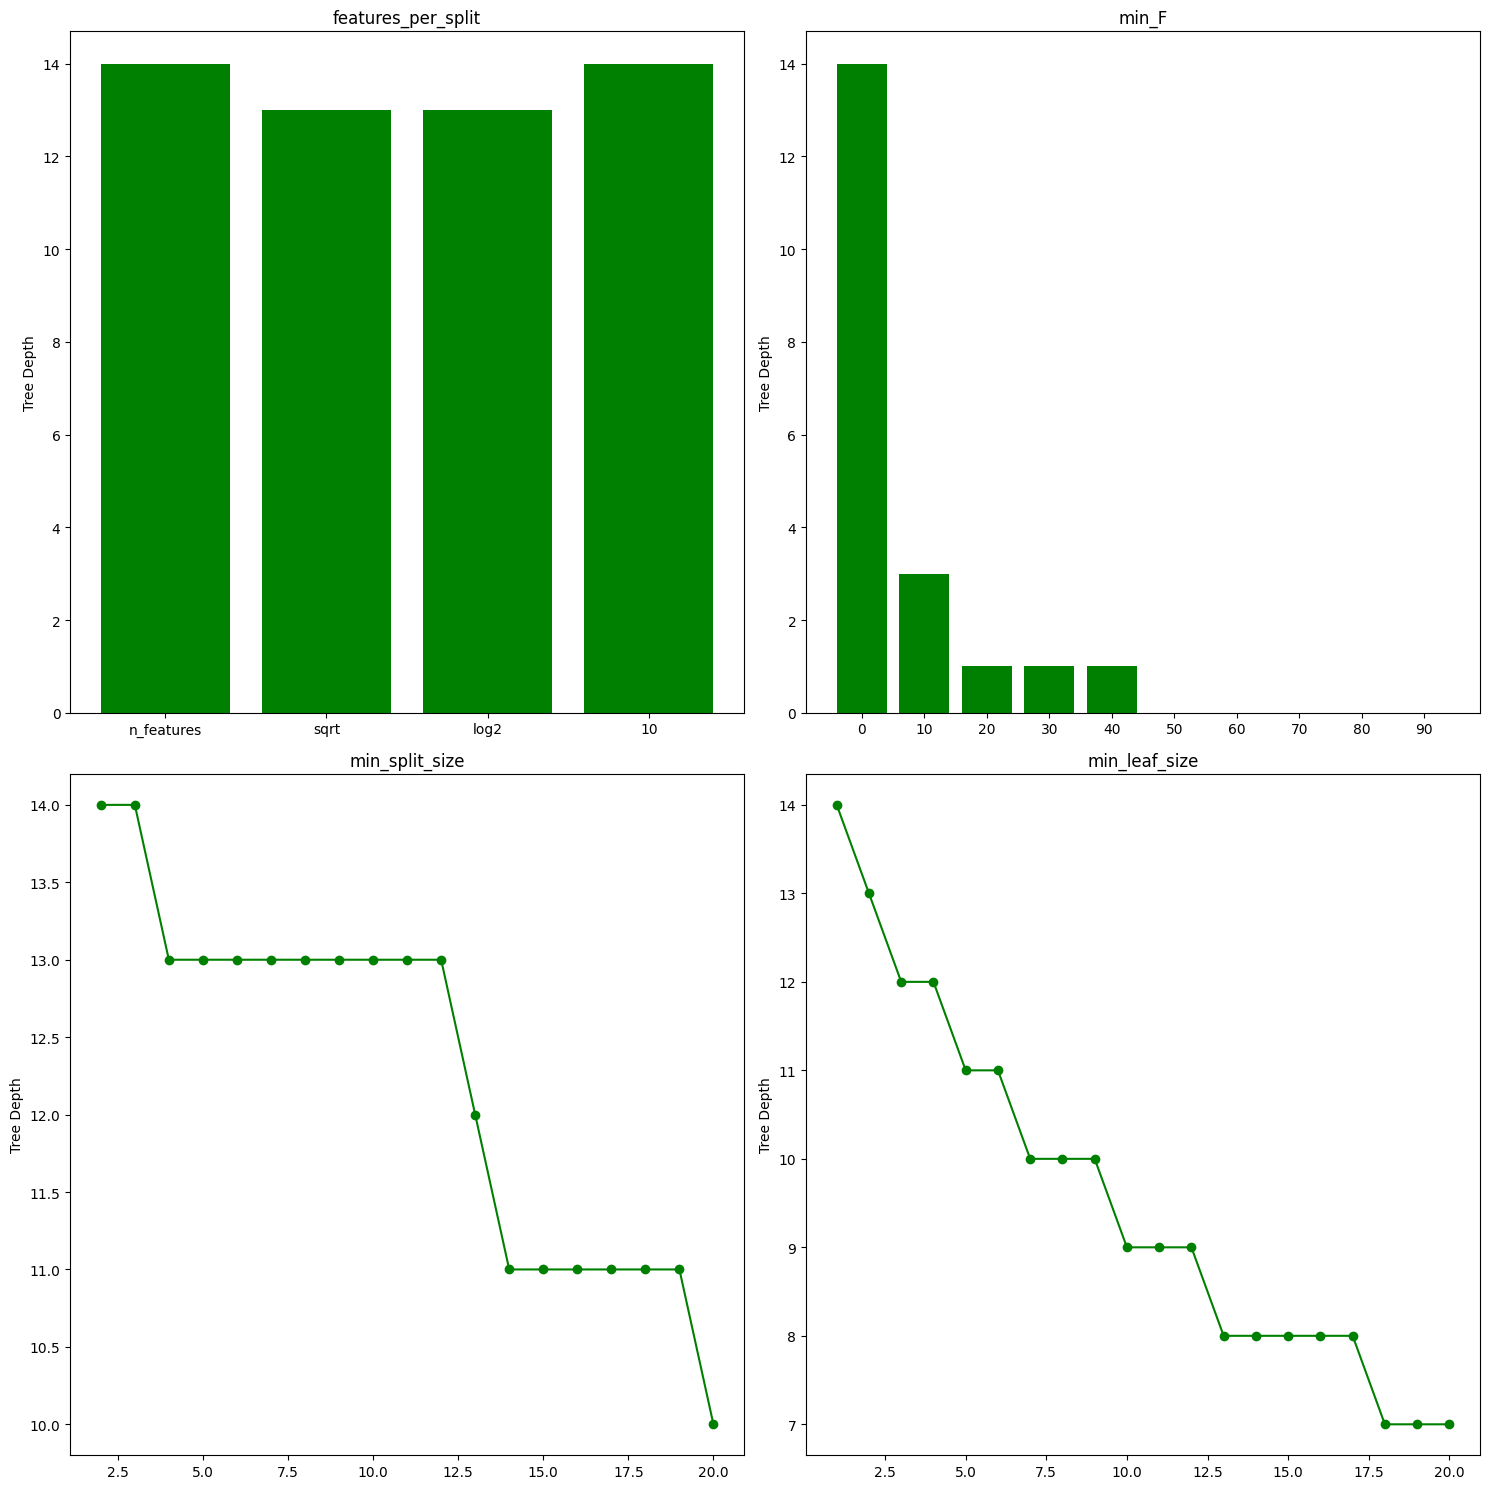

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

params_tree_custom = {
    "features_per_split": [None, 'sqrt', 'log2', 10],
    "min_F": range(0, 100, 10),
    "min_split_size": range(2, 21),
    "min_leaf_size": range(1, 21),
}

def iterate_through_parameter_custom(name, values):
    depths = []
    for value in values:
        tree_clf = DecisionTree(**{name: value})
        tree_clf.fit(X_train.values, y_train.values)
        depths.append(tree_clf.get_depth())
    return depths


fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

for ind, (name, values) in tqdm(enumerate(params_tree_custom.items())):
    depths = iterate_through_parameter_custom(name, values)
    if name == 'features_per_split' and values[0] is None:
        values[0] = 'n_features'

    if name == 'min_split_size' or name == 'min_leaf_size':
        axes[ind].plot(values, depths, color='green', marker='o')
    else:
        axes[ind].bar(list(map(str, values)), depths, color='green')
    axes[ind].set_title(name)
    axes[ind].set_ylabel("Tree Depth")

plt.tight_layout()
plt.show()

### Графики целевой функции качества для Деревьев

In [18]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

depths = range(1, 20)

def iterate_through_depths(model):
    train_accuracies = []
    test_accuracies = []
    
    for max_depth in tqdm(depths):
        clf = model(max_depth=max_depth)
        clf.fit(X_train.values, y_train.values)

        y_pred_train = clf.predict(X_train.values)
        y_pred_test = clf.predict(X_test.values)

        train_accuracies.append(accuracy_score(y_pred_train, y_train))
        test_accuracies.append(accuracy_score(y_pred_test, y_test))
    
    return train_accuracies, test_accuracies

def draw_plot(parameter, parameter_name, train_accuracies, test_accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(parameter, train_accuracies, label='Train Accuracy', marker='o', color='blue')
    plt.plot(parameter, test_accuracies, label='Test Accuracy', marker='o', color='orange')
    plt.xlabel(parameter_name)
    plt.ylabel('Accuracy')
    plt.title('Train and Test accuracy comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

Для собственной реализации

In [80]:
train_acc_custom, test_acc_custom = iterate_through_depths(DecisionTree)

100%|██████████| 19/19 [00:22<00:00,  1.21s/it]


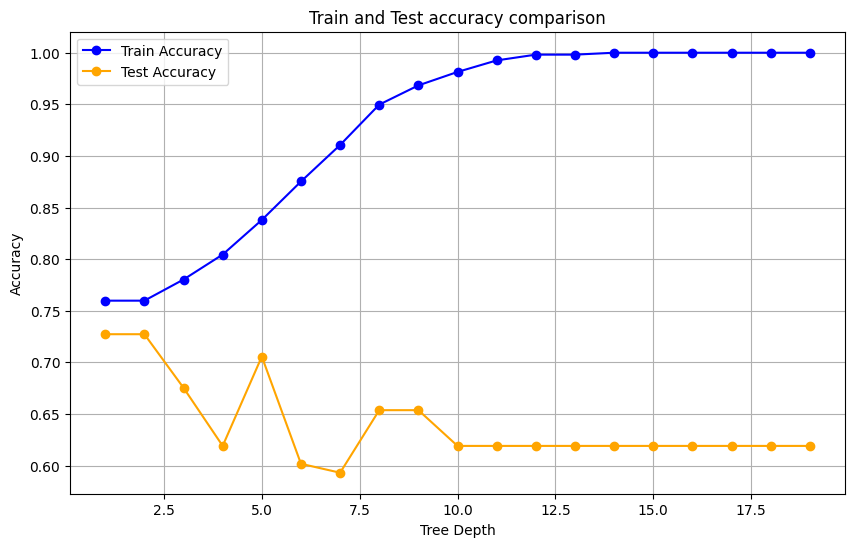

In [98]:
draw_plot(depths, 'Tree depth', train_acc_custom, test_acc_custom)

Для библиотечной реализации

In [92]:
from sklearn.tree import DecisionTreeClassifier

train_acc_sk, test_acc_sk = iterate_through_depths(DecisionTreeClassifier)

100%|██████████| 19/19 [00:00<00:00, 322.40it/s]


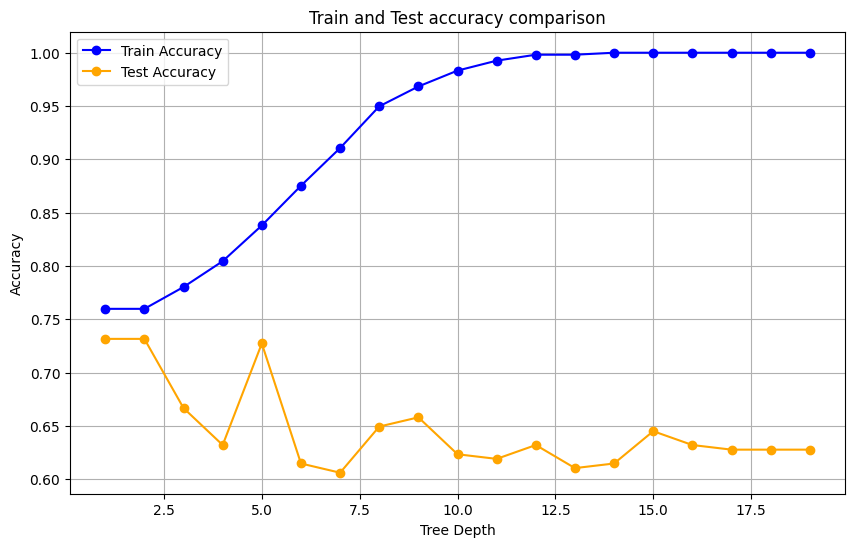

In [99]:
draw_plot(depths, 'Tree Depth', train_acc_sk, test_acc_sk)

### Графики целевой функции качества для Леса

In [16]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

trees = range(1, 10 + 1)

def iterate_through_trees(model):
    train_accuracies = []
    test_accuracies = []

    for n_trees in tqdm(trees):
        clf = model(n_trees=n_trees)
        clf.fit(X_train.values, y_train.values)

        y_pred_train = clf.predict(X_train.values)
        y_pred_test = clf.predict(X_test.values)

        train_accuracies.append(accuracy_score(y_pred_train, y_train))
        test_accuracies.append(accuracy_score(y_pred_test, y_test))
    
    return train_accuracies, test_accuracies

Для собственной реализации

In [13]:
train_acc_forest_custom, test_acc_forest_custom = iterate_through_trees(RandomForest)

100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


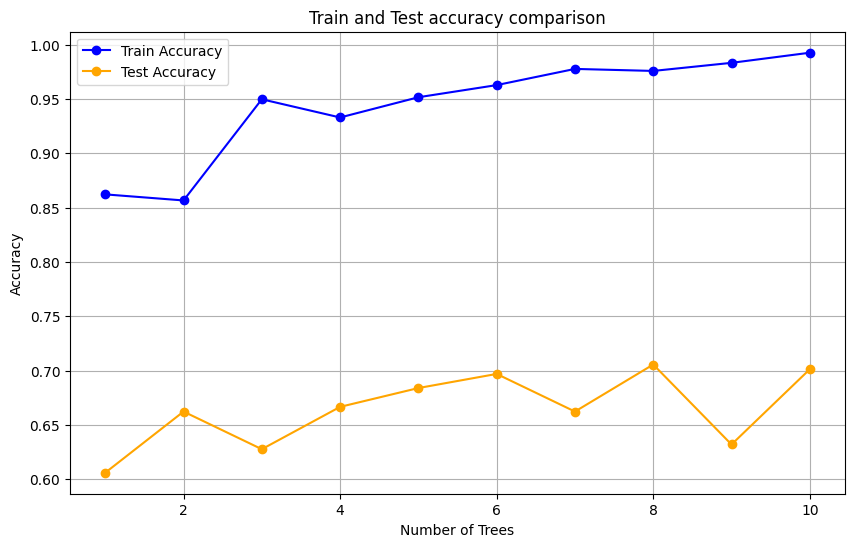

In [19]:
draw_plot(trees, 'Number of Trees', train_acc_forest_custom, test_acc_forest_custom)

Для библиотечной реализации

In [21]:
def iterate_through_trees_sk(model):
    train_accuracies = []
    test_accuracies = []

    for n_trees in tqdm(trees):
        clf = model(n_estimators=n_trees)
        clf.fit(X_train.values, y_train.values)

        y_pred_train = clf.predict(X_train.values)
        y_pred_test = clf.predict(X_test.values)

        train_accuracies.append(accuracy_score(y_pred_train, y_train))
        test_accuracies.append(accuracy_score(y_pred_test, y_test))
    
    return train_accuracies, test_accuracies

In [24]:
from sklearn.ensemble import RandomForestClassifier

train_acc_forest_sk, test_acc_forest_sk = iterate_through_trees_sk(RandomForestClassifier)

100%|██████████| 10/10 [00:00<00:00, 101.79it/s]


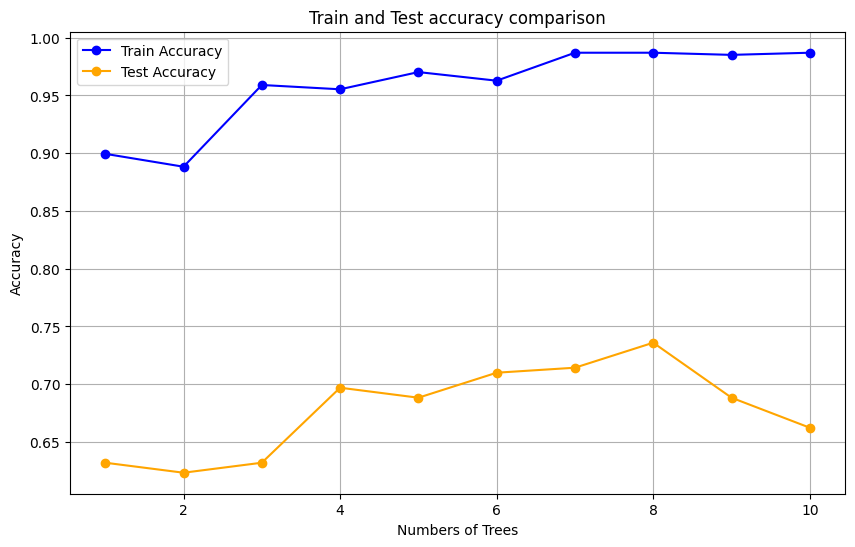

In [25]:
draw_plot(trees, 'Numbers of Trees', train_acc_forest_sk, test_acc_forest_sk)

### Бустинг

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

train_acc_boost, test_acc_boost = iterate_through_trees_sk(GradientBoostingClassifier)

100%|██████████| 10/10 [00:00<00:00, 88.02it/s]


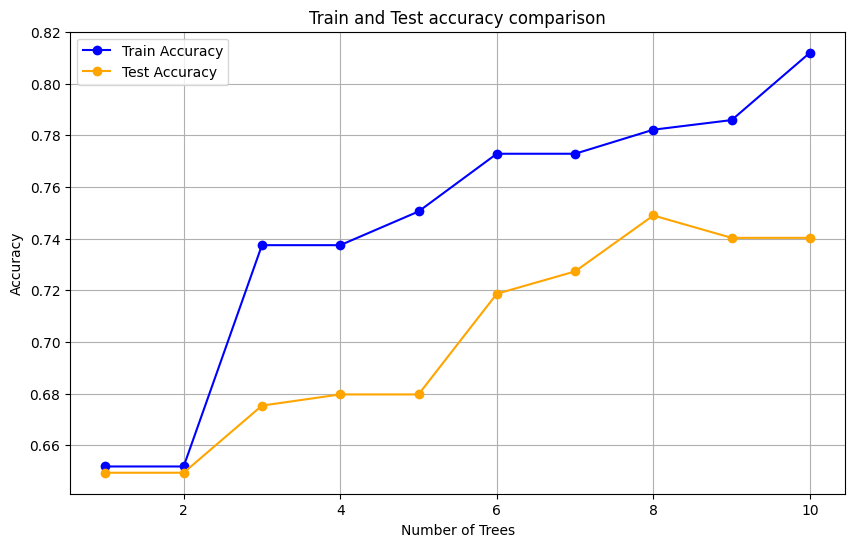

In [28]:
draw_plot(trees, 'Number of Trees', train_acc_boost, test_acc_boost)